# T036 · Uncertainty estimation

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Michael Backenköhler, 2022, [Volkamer lab](https://volkarmerlab.org), Saarland University

*The example used in this talktorial template is taken from [__Talktorial T022__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_network/talktorial.ipynb).*

## Aim of this talktorial

Add a short summary of this talktorial's content.

### Contents in *Theory*

_Add Table of Contents (TOC) for Theory section._

* ChEMBL database
* Compound activity measures

### Contents in *Practical*

_Add Table of Contents (TOC) for Practical section._

* Connect to ChEMBL database
* Load and draw molecules

<div class="alert alert-block alert-info">

<b>Sync TOC with section titles</b>: These points should refer to the headlines of your <i>Practical</i> section.

</div>

### References

* Paper 
* [__Talktorial T022__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_network/talktorial.ipynb)
* Other useful resources

*We suggest the following citation style:*
* Keyword describing resource: <i>Journal</i> (year), <b>volume</b>, pages (link to resource) 

*Example:*
* ChEMBL web services: [<i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620](https://academic.oup.com/nar/article/43/W1/W612/2467881) 

## Theory

### Aleatoric uncertainty

### Epistemic uncertainty

### Confidence curves and calibration

## Practical

Add short summary of what will be done in this practical section.

<div class="alert alert-block alert-info">

<b>Sync section titles with TOC</b>: Please make sure that all section titles in the <i>Practical</i> section are synced with the bullet point list provided in the <i>Aim of this talktorial</i> > <i>Contents in Practical</i> section.

</div>

<div class="alert alert-block alert-info">
    
<b>Beware of section levels</b>: Please check if you are using the correct subsection levels. The section <i>Practical</i> is written in Markdown as <code>## Practical</code>, so every subsection within <i>Practical</i> is <code>###</code> or lower.

</div>

In [1]:
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from scipy.stats import norm

import tensorflow as tf

from t022 import neural_network_model, smiles_to_fp, load_chembl_egfr_data, create_and_fit_model

%matplotlib inline

<div class="alert alert-block alert-info">

<b>Imports</b>: Please add all your imports on top of this section, ordered by standard library / 3rd party packages / our own (<code>teachopencadd.*</code>). 
Read more on imports and import order in the <a href="https://www.python.org/dev/peps/pep-0008/#imports">"PEP 8 -- Style Guide for Python Code"</a>.
    
</div>

In [2]:
import tqdm

In [3]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

<div class="alert alert-block alert-info">

<b>Relative paths</b>: Please define all paths relative to this talktorial's path by using the global variable <code>HERE</code>.
If your talktorial has input/output data, please define the global <code>DATA</code>, which points to this talktorial's data folder (check out the default folder structure of each talktorial).
    
</div>

### Connect to ChEMBL database

Load data.

In [4]:
chembl_df = load_chembl_egfr_data(DATA / "CHEMBL25_activities_EGFR.csv", method='morgan3', n_bits=2024)
x_train, x_test, y_train, y_test = train_test_split(
    chembl_df["fingerprints_df"], chembl_df["pIC50"], test_size=0.3, random_state=42
)
x_test = tf.convert_to_tensor(np.array([np.array(a, dtype=int) for a in x_test], dtype=int))
x_train = tf.convert_to_tensor(np.array([np.array(a, dtype=int) for a in x_train], dtype=int))
y_train = tf.constant(y_train)
y_test = tf.constant(y_test)

2022-12-07 16:19:22.220184: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-07 16:19:22.220430: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 16:19:22.231664: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


We now set up the pipeline of creating and training a model.

In [89]:
ensemble_size = 20
ensemble = []
for _ in tqdm.tqdm(range(ensemble_size)):
    model = create_and_fit_model(x_train, y_train, x_test, y_test,
                                 layers=[1024, 512, 256, 128, 64], verbose=0, batch_size=32, epochs=15)
    ensemble.append(model)

100%|███████████████████████████████████████████| 20/20 [11:58<00:00, 35.93s/it]


In [90]:
preds = np.array([model.predict(x_test) for model in ensemble]).reshape(ensemble_size, len(x_test))

In [91]:
stds = preds.std(0)
var = preds.var(0)
mean = preds.mean(0)
mae = np.abs(preds - y_test).sum(0)
mse = np.sum((preds - y_test) ** 2, 0)

In [92]:
np.corrcoef(mean, y_test)

array([[1.       , 0.8441611],
       [0.8441611, 1.       ]])

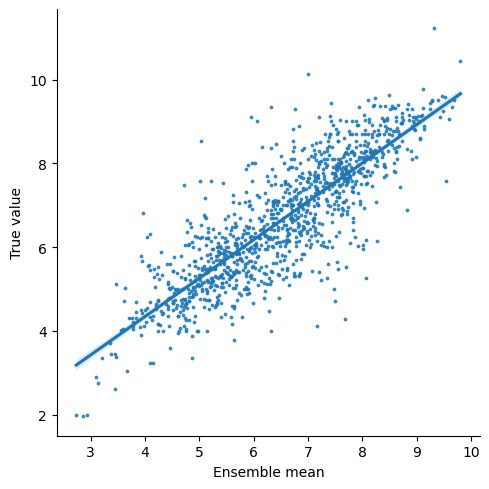

In [93]:
sns.lmplot(pd.DataFrame({'Ensemble mean': mean, 'True value': y_test}), x='Ensemble mean', y='True value', scatter_kws={'s': 3});

Text(0, 0.5, 'MAE')

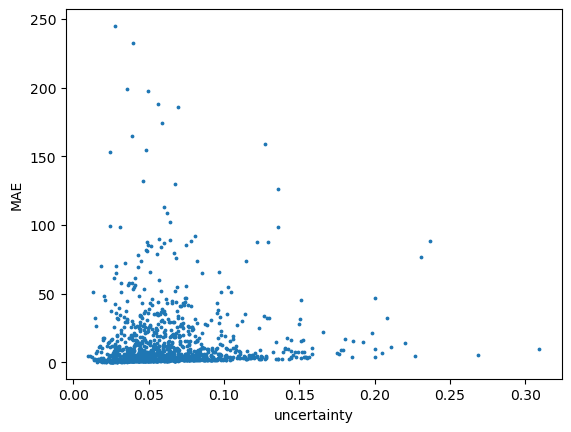

In [94]:
plt.scatter(var, mse, s=3)
plt.xlabel('uncertainty')
plt.ylabel('MAE')
# plt.yscale('log')
# plt.xscale('log')

In [95]:
np.corrcoef(mae, stds)

array([[1.        , 0.02647844],
       [0.02647844, 1.        ]])

In [96]:
confidences = np.linspace(.0, 1)

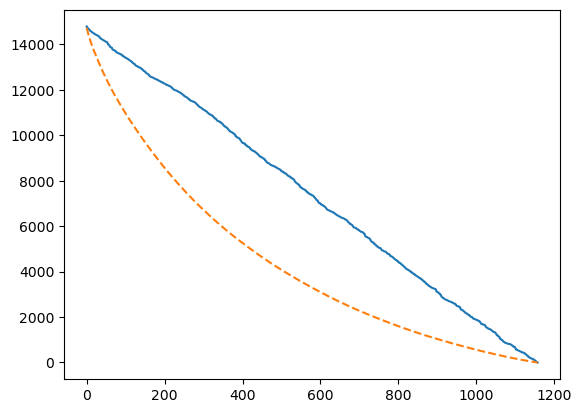

In [107]:
idcs_mae = np.argsort(mae)[::-1]
idcs_conf = np.argsort(stds)[::-1]
plt.plot(mae.sum() - np.cumsum(mae[idcs_conf]))
plt.plot(mae.sum() - np.cumsum(mae[idcs_mae]), '--')

In [97]:
hits = []
for c in confidences:
    delta = stds * norm.ppf(.5 + c / 2) / np.sqrt(len(ensemble))
    a = np.array((mean - delta < y_test) & (mean + delta > y_test)).astype(int)
    hits.append(a.sum() / len(a))

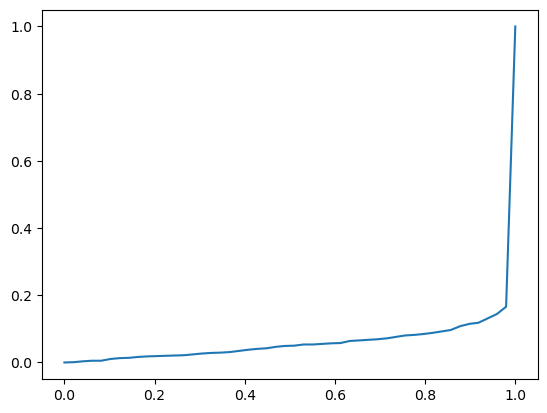

In [98]:
plt.plot(confidences, hits)
plt.yscale('linear')

#### Bagging ensemble

In [69]:
ensemble_size = 20
ensemble_bagg = []
for _ in tqdm.tqdm(range(ensemble_size)):
    idcs = np.random.choice(np.arange(len(x_train)), size=len(x_train), replace=True)
    x_train_resample = tf.gather(x_train, tf.constant(idcs))
    y_train_resample = tf.gather(y_train, tf.constant(idcs))
    model = create_and_fit_model(x_train_resample, y_train_resample, x_test, y_test,
                                 layers=[1024, 512, 256, 128, 64], verbose=0, batch_size=32, epochs=20)
    ensemble_bagg.append(model)

100%|███████████████████████████████████████████| 20/20 [10:04<00:00, 30.21s/it]


In [87]:
preds_bagg = np.array([model.predict(x_test) for model in ensemble_bagg]).reshape(ensemble_size, len(x_test))

In [88]:
stds_bagg = preds.std(0)
var_bagg = preds.var(0)
mean_bagg = preds.mean(0)
mae_bagg = np.abs(preds_bagg - y_test).sum(0)
mse_bagg = np.sum((preds_bagg - y_test) ** 2, 0)

In [72]:
np.corrcoef(mean_bagg, y_test)

array([[1.        , 0.82998387],
       [0.82998387, 1.        ]])

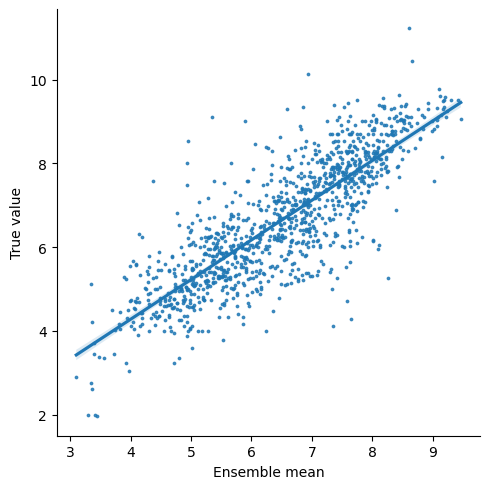

In [73]:
sns.lmplot(pd.DataFrame({'Ensemble mean': mean_bagg, 'True value': y_test}), x='Ensemble mean', y='True value', scatter_kws={'s': 3});

In [74]:
confidences = np.linspace(0, 1)
hits_bagg = []
for c in confidences:
    delta = stds_bagg * norm.ppf(.5 + c / 2) / np.sqrt(len(ensemble))
    a = np.array((mean_bagg - delta < y_test) & (mean_bagg + delta > y_test)).astype(int)
    hits_bagg.append(a.sum() / len(a))

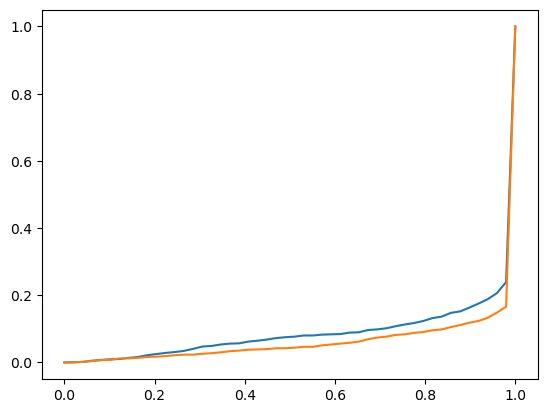

In [75]:
plt.plot(confidences, hits_bagg)
plt.plot(confidences, hits)
plt.yscale('linear')

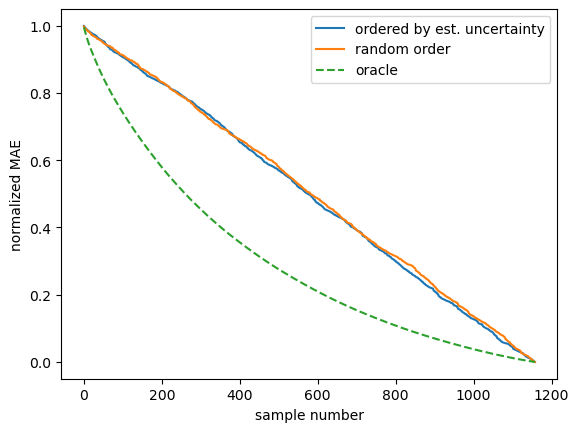

In [129]:
idcs_mae = np.argsort(mae)[::-1]
idcs_conf = np.argsort(stds)[::-1]
plt.plot((mae.sum() - np.cumsum(mae[idcs_conf])) / mae.sum(), label='ordered by est. uncertainty')
np.random.shuffle(idcs_conf)
plt.plot((mae.sum() - np.cumsum(mae[idcs_conf])) / mae.sum(), label='random order')
plt.plot((mae.sum() - np.cumsum(mae[idcs_mae])) / mae.sum(), '--', label='oracle')
plt.legend()
plt.xlabel('sample number')
plt.ylabel('normalized MAE');

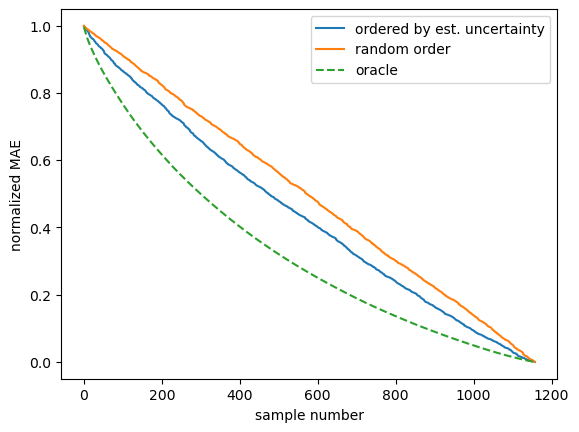

In [130]:
idcs_mae = np.argsort(mae_bagg)[::-1]
idcs_conf = np.argsort(stds_bagg)[::-1]
plt.plot((mae_bagg.sum() - np.cumsum(mae_bagg[idcs_conf])) / mae_bagg.sum(), label='ordered by est. uncertainty')
np.random.shuffle(idcs_conf)
plt.plot((mae_bagg.sum() - np.cumsum(mae_bagg[idcs_conf])) / mae_bagg.sum(), label='random order')
plt.plot((mae_bagg.sum() - np.cumsum(mae_bagg[idcs_mae])) / mae_bagg.sum(), '--', label='oracle')
plt.legend()
plt.xlabel('sample number')
plt.ylabel('normalized MAE');

<div class="alert alert-block alert-info">

<b>Functions</b>: 

<ul>
<li>Please add <a href="https://numpydoc.readthedocs.io/en/latest/format.html">numpy docstrings</a> to your functions.</li>
<li>Please expose all variables used within a function in the function's signature (i.e. they must be function parameters), unless they are created within the scope of the function.</li>
<li>Please add comments to the steps performed in the function.</li>
<li>Please use meaningful function and parameter names. This applies also to variable names.</li>
</ul>
    
</div>

## Discussion

Wrap up the talktorial's content here and discuss pros/cons and open questions/challenges.

## Quiz

Ask three questions that the user should be able to answer after doing this talktorial. Choose important take-aways from this talktorial for your questions.

1. Question
2. Question
3. Question

<div class="alert alert-block alert-info">

<b>Useful checks at the end</b>: 
    
<ul>
<li>Clear output and rerun your complete notebook. Does it finish without errors?</li>
<li>Check if your talktorial's runtime is as excepted. If not, try to find out which step(s) take unexpectedly long.</li>
<li>Flag code cells with <code># NBVAL_CHECK_OUTPUT</code> that have deterministic output and should be tested within our Continuous Integration (CI) framework.</li>
</ul>

</div>